In [1]:
#ISH
#Writtem by Inseung Hwang
#COBI Lab, KNU
#2022-03-20

In [2]:
Sys.umask("006")

In [ ]:
# Please make sure there is no any file on out_dir

In [ ]:
library(Seurat)
library(SeuratDisk)
library(ggplot2)
#library(patchwork)
library(png)
library(patchwork)
library(dplyr)

Attaching SeuratObject

Attaching sp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [ ]:
#Automation option
dir <- '/data2/COVID19/adjusted_data_link/COVID_Matrix_Raw/'
out_dir <- '/data2/COVID19/analysis/KNU/azimuth_label_adjusted/'

project <- list.files(dir)
path <- paste0(dir, project,sep='')
out_path <- paste0(out_dir,project,sep='')

file_df <- data.frame(project, path,out_path)
head(file_df, n = 3)

,project,path,out_path
,<chr>,<chr>,<chr>
1,COV.CCO.0011,/data2/COVID19/adjusted_data_link/COVID_Matrix_Raw/COV.CCO.0011,/data2/COVID19/analysis/KNU/azimuth_label_NOQC/COV.CCO.0011
2,COV.CCO.0012,/data2/COVID19/adjusted_data_link/COVID_Matrix_Raw/COV.CCO.0012,/data2/COVID19/analysis/KNU/azimuth_label_NOQC/COV.CCO.0012
3,COV.CCO.0013,/data2/COVID19/adjusted_data_link/COVID_Matrix_Raw/COV.CCO.0013,/data2/COVID19/analysis/KNU/azimuth_label_NOQC/COV.CCO.0013


In [ ]:
#Input file of seurat object
seurat_input = "/data1/home/histidine/project/notebook/Data/pbmc_multimodal.h5seurat"

reference <- LoadH5Seurat(seurat_input)

Validating h5Seurat file

Initializing ADT with data

Adding counts for ADT

Adding variable feature information for ADT

Adding miscellaneous information for ADT

Initializing SCT with data

Adding counts for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction apca

Adding cell embeddings for apca

Adding feature loadings for apca

Adding miscellaneous information for apca

Adding reduction aumap

Adding cell embeddings for aumap

Adding miscellaneous information for aumap

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction spca

Adding cell embeddings for spca

Adding feature loadings for spca

Adding miscellaneous information for spca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding reduction wnn.umap

Adding cell embeddings for wnn.umap

Adding miscellaneous information for w


# Make function easy control of memory

In [ ]:
azimuth_labeling <- function(pjt, pth, opth, reference, nCount_RNA_limit, nFeature_RNA_limit, percent_mt_limit, min_cells_limit, min_features_limit) {
    
    ################
    #Parameter setting
    #nCount_RNA_limit = 20000
    #nFeature_RNA_limit = 4000
    #percent_mt_limit = 10
    #min_cells_limit = 2
    #min_features_limit = 300
    ################
    #Read raw_counts
    mtx <-paste(pth,"/","matrix.mtx.gz",sep="")
    features <-paste(pth,"/","features.tsv.gz",sep="")
    cells<-paste(pth,"/","barcodes.tsv.gz",sep="")

    pbmc.data <- ReadMtx(
        mtx,
        cells,
        features,
        cell.column = 1, #column of cells file
        feature.column = 2, #2 means gene symbol 1 means ENSEMBL gene name
        unique.features = TRUE
    )
    pbmc <- CreateSeuratObject(counts = pbmc.data, project = pjt, min.cells = min_cells_limit, min.features = min_features_limit)
    #Number of featrues
    before_features <- dim(x = pbmc)[1]
    #Number of cells
    before_cells <- dim(x = pbmc)[2]

    ################
    #Quality Control
    # pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
    # pbmc
    
    # QC_ViolinPlot.png
    #plot_pth = paste(opth,"/QC_ViolinPlot.png",sep="")
    #p = VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt") , ncol = 3)
    # png(file = plot_pth)
    # print(p)
    # dev.off()
    
    # MT_cutoff.png
    # plot_pth = paste(opth,"/MT_cutoff.png",sep="")
    # p <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")# + geom_hline(yintercept=10)
    # png(file = plot_pth)
    # print(p)
    # dev.off()

    
    #QC_Gene_cutoff.png
    # plot_pth = paste(opth,"/QC_Gene_cutoff.png",sep="")
    # p <- FeatureScatter(pbmc, feature1 = "nFeature_RNA", feature2 = "nCount_RNA")# + geom_hline(yintercept=20000) + geom_vline(xintercept = 4000)
    # png(file = plot_pth)
    # print(p)
    # dev.off()
    
    ################
    #QC filtering
    #pbmc <- subset(pbmc, subset = nCount_RNA < nCount_RNA_limit & nFeature_RNA < nFeature_RNA_limit & percent.mt < percent_mt_limit)
    
    #Number of featrues
    #after_features <- dim(x = pbmc)[1]
    #Number of genes
    #after_cells <- dim(x = pbmc)[2]
    
    ################
    #Normalization
    pbmc_norm <- SCTransform(pbmc, verbose = FALSE)
    
    ################
    #Labeling 
    anchors <- FindTransferAnchors(
        reference = reference,
        query = pbmc_norm,
        normalization.method = "SCT",
        reference.reduction = "spca",
        dims = 1:50
    )

    pbmc_norm <- MapQuery(
        anchorset = anchors,
        query = pbmc_norm,
        reference = reference,
        refdata = list(
            celltype.l1 = "celltype.l1",
            celltype.l2 = "celltype.l2",
            predicted_ADT = "ADT"
        ),
        reference.reduction = "spca", 
        reduction.model = "wnn.umap"
    )
    
    pbmc_df <- as.data.frame(pbmc_norm[[]])
    
    
    ################
    #Save label
    celltype_file_name_l1 <- paste(opth,"/",pjt,"_cell_type_annot_l1.tsv", sep="")
    write.table(pbmc_df['predicted.celltype.l1'], file=celltype_file_name_l1, quote=F, sep="\t", col.names = F)
    
    celltype_file_name_l2 <- paste(opth,"/",pjt,"_cell_type_annot_l2.tsv", sep="")
    write.table(pbmc_df['predicted.celltype.l2'], file=celltype_file_name_l2, quote=F, sep="\t", col.names = F)
    
    ################
    #Save figure
    # plot_pth <- paste(opth,"/",pjt,"_cell_type_annot_l1.pdf", sep="")
    # p = DimPlot(pbmc_norm, reduction = "ref.umap", group.by = "predicted.celltype.l1", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
    # pdf(plot_pth) 
    # print(p)
    # dev.off()

    # plot_pth <- paste(opth,"/",pjt,"_cell_type_annot_l2.pdf", sep="")
    # p = DimPlot(pbmc_norm, reduction = "ref.umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 3 ,repel = TRUE) + NoLegend()
    # pdf(plot_pth) 
    # print(p)
    # dev.off() 
    
    
    ################
    #Save data condition
    # writeLines(
    #     c(paste("Project:",pjt,sep=":\t"),
    #       paste("Input directory:",pth,sep=":\t"),
    #       "",
    #       paste("Without genes with fewer than number of cells:",min_cells_limit,sep=":\t"),
    #       paste("Without cells with fewer than number of genes :",min_features_limit,sep=":\t"),
    #       "",
    #       paste("Before filtering(Number of features):",before_features,sep=":\t"),
    #       paste("Before filtering(Number of genes):",before_cells,sep=":\t"),
    #       "",
    #       paste("Maximum UMI count:",nCount_RNA_limit,sep=":\t"),
    #       paste("Maximum Feature number:",nFeature_RNA_limit,sep=":\t"),
    #       paste("Maximum percent of mitochondria:",percent_mt_limit,sep=":\t"),
    #       "",
    #       paste("After filtering(Number of features):",after_features,sep=":\t"),
    #       paste("After filtering(Number of genes):",after_cells,sep=":\t"),
    #       "")
    #     , paste(opth,"/","README.txt",sep=""))

    #return(full_path)
}


In [ ]:
# #Test no loop

# pjt <- "COV.CCO.0011"
# pth <- "/data2/COVID19/adjusted_data_link/COVID_Matrix_Raw/COV.CCO.0011"
# pth <- "/data2/COVID19/analysis/KNU/azimuth_label_adjusted/COV.CCO.0011"


# #Read raw_counts
# mtx <-paste(pth,"/","matrix.mtx.gz",sep="")
# features <-paste(pth,"/","features.tsv.gz",sep="")
# cells<-paste(pth,"/","barcodes.tsv.gz",sep="")

# pbmc.data <- ReadMtx(
#     mtx,
#     cells,
#     features,
#     cell.column = 1, #column of cells file
#     feature.column = 2, #2 means gene symbol 1 means ENSEMBL gene name
#     unique.features = TRUE
# )
# pbmc <- CreateSeuratObject(counts = pbmc.data, project = pjt, min.cells = min_cells_limit, min.features = min_features_limit)
# #Number of featrues
# before_features <- dim(x = pbmc)[1]
# #Number of cells
# before_cells <- dim(x = pbmc)[2]

# ################
# #Quality Control
# #pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# pbmc

# # QC_ViolinPlot.png
# plot_pth = paste(opth,"/QC_ViolinPlot.png",sep="")
# p = VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt") , ncol = 3)
# png(file = plot_pth)
# print(p)
# dev.off()

# # MT_cutoff.png
# plot_pth = paste(opth,"/MT_cutoff.png",sep="")
# p <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_hline(yintercept=10)
# png(file = plot_pth)
# print(p)
# dev.off()


# #QC_Gene_cutoff.png
# plot_pth = paste(opth,"/QC_Gene_cutoff.png",sep="")
# p <- FeatureScatter(pbmc, feature1 = "nFeature_RNA", feature2 = "nCount_RNA") + geom_hline(yintercept=20000) + geom_vline(xintercept = 4000)
# png(file = plot_pth)
# print(p)
# dev.off()

# ################
# #QC filtering
# pbmc <- subset(pbmc, subset = nCount_RNA < nCount_RNA_limit & nFeature_RNA < nFeature_RNA_limit & percent.mt < percent_mt_limit)

# #Number of featrues
# after_features <- dim(x = pbmc)[1]
# #Number of genes
# after_cells <- dim(x = pbmc)[2]

# ################
# #Normalization
#     pbmc_norm <- SCTransform(pbmc, verbose = FALSE)

# ################
# #Labeling 
# anchors <- FindTransferAnchors(
#     reference = reference,
#     query = pbmc_norm,
#     normalization.method = "SCT",
#     reference.reduction = "spca",
#     dims = 1:50
# )

# pbmc_norm <- MapQuery(
#     anchorset = anchors,
#     query = pbmc_norm,
#     reference = reference,
#     refdata = list(
#         celltype.l1 = "celltype.l1",
#         celltype.l2 = "celltype.l2",
#         predicted_ADT = "ADT"
#     ),
#     reference.reduction = "spca", 
#     reduction.model = "wnn.umap"
# )

# pbmc_df <- as.data.frame(pbmc_norm[[]])



# For loop with path DataFrame

In [ ]:
for (row in 1:nrow(file_df)) {
    pjt <- file_df[row, "project"]
    pth <- file_df[row, "path"]
    opth <- file_df[row, "out_path"]
    
    print(opth)
    if(!file.exists(opth)){
        dir.create(opth,showWarnings = TRUE, recursive = FALSE,  mode = "0770")
        
    }else{
        print(paste("Aleady exist project : ",pjt))
        print("Remove existing directory")
        unlink(opth,recursive=TRUE)
        dir.create(opth,showWarnings = TRUE, recursive = FALSE,  mode = "0770")
    }
    ################
    #Parameter setting
    nCount_RNA_limit = 20000
    nFeature_RNA_limit = 4000
    percent_mt_limit = 10
    min_cells_limit = 2
    min_features_limit = 300
    
    azimuth_labeling(pjt,pth,opth,reference,nCount_RNA_limit,nFeature_RNA_limit,percent_mt_limit, min_cells_limit, min_features_limit)
    break
    
    #Only loop 3 times for testintg
    if(row > 3){
        print("end")
        break
    }
}

[1] "/data2/COVID19/analysis/KNU/azimuth_label_NOQC/COV.CCO.0011"
[1] "Aleady exist project :  COV.CCO.0011"
[1] "Remove existing directory"


Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods



# Save Reference plots

In [ ]:
plot1_file_name <- paste(out_dir,"reference_cell_annot_l1.pdf", sep="")
plot1_file_name
plot2_file_name <- paste(out_dir,"reference_cell_annot_l2.pdf", sep="")
plot2_file_name


[1] "/data2/COVID19/analysis/KNU/azimuth_label_NOQC/reference_cell_annot_l1.pdf"

[1] "/data2/COVID19/analysis/KNU/azimuth_label_NOQC/reference_cell_annot_l2.pdf"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

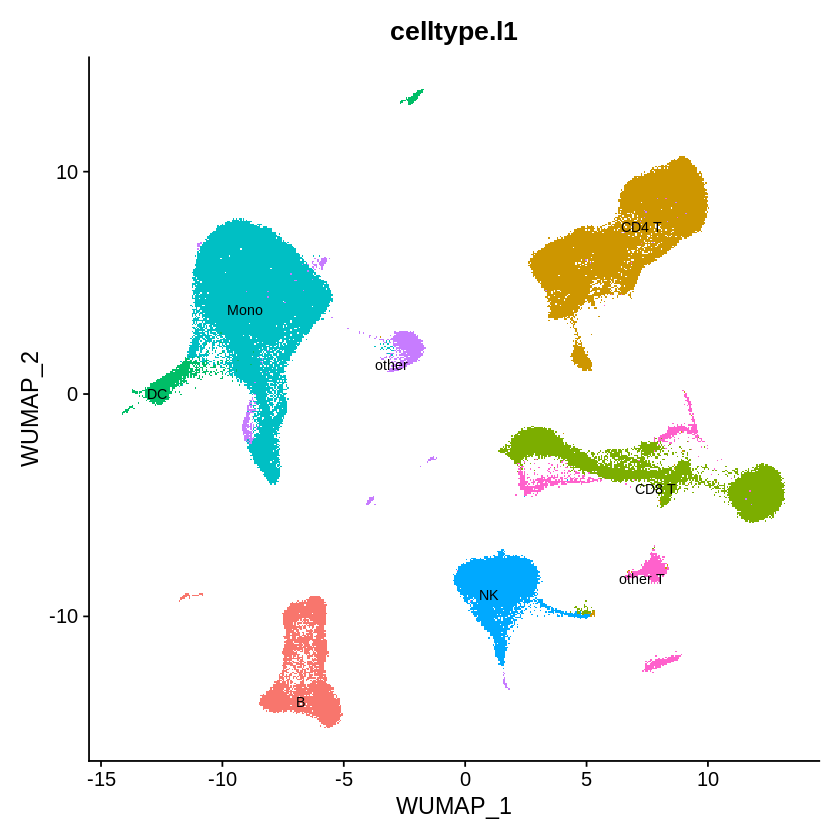

In [ ]:
p1 = DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l1", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
# Open a pdf file
pdf(plot1_file_name) 
# 2. Create a plot
p1
# Close the pdf file
dev.off() 
p1

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

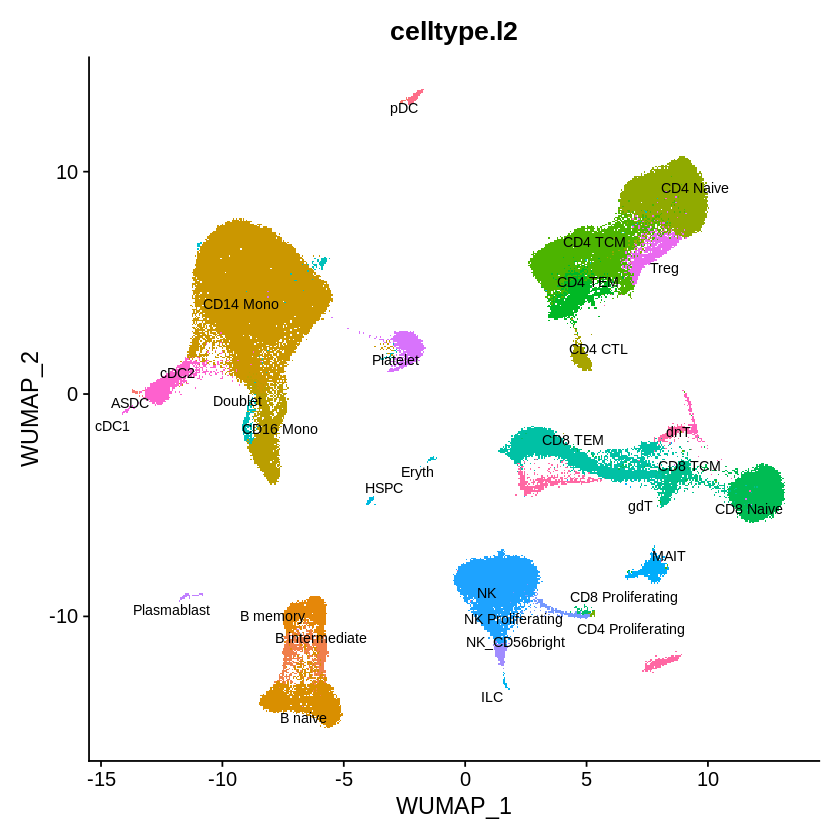

In [ ]:
p2 = DimPlot(object = reference, reduction = "wnn.umap", group.by = "celltype.l2", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
# Open a pdf file
pdf(plot2_file_name) 
# 2. Create a plot
p2
# Close the pdf file
dev.off()
p2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



ERROR: Error in is.factor(x): object 'plot3_file_name' not found
